<a href="https://colab.research.google.com/github/utsavnandi/Kaggle-SIIM-ISIC-Melanoma-Classification/blob/master/SIIM_ISIC_Melanoma_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## One-time


In [3]:
%%writefile setup.sh
pip uninstall kaggle -y
pip install kaggle==1.5.6 -q
pip install -U git+https://github.com/albu/albumentations -q
pip install -U git+https://github.com/rwightman/pytorch-image-models -q
pip install neptune-client -q
git clone https://github.com/galatolofederico/pytorch-balanced-batch.git
mv ./pytorch-balanced-batch/sampler.py ./sampler.py
rm -rf ./pytorch-balanced-batch/
mkdir ~/.kaggle/
cp ./kaggle.json  ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download tunguz/siimisic-melanoma-resized-images -f x_train_224.npy
kaggle datasets download tunguz/siimisic-melanoma-resized-images -f x_test_224.npy
unzip ./680899%2F1200702%2Fcompressed%2Fx_train_224.npy.zip -d ./data/
unzip ./680899%2F1200702%2Fcompressed%2Fx_test_224.npy.zip -d ./data/
rm ./680899%2F1200702%2Fcompressed%2Fx_train_224.npy.zip
rm ./680899%2F1200702%2Fcompressed%2Fx_test_224.npy.zip
kaggle competitions download siim-isic-melanoma-classification -f sample_submission.csv
kaggle competitions download siim-isic-melanoma-classification -f test.csv
kaggle competitions download siim-isic-melanoma-classification -f train.csv
unzip train.csv -d ./data/
mv ./test.csv ./data/
mv ./sample_submission.csv ./data/
rm train.csv.zip
mkdir ./logs/

Overwriting setup.sh


In [4]:
!sh setup.sh

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Cloning into 'pytorch-balanced-batch'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 26 (delta 0), reused 1 (delta 0), pack-reused 23
Unpacking objects: 100% (26/26), done.
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
100% 3.45G/3.46G [01:06<00:00, 43.6MB/s]
100% 3.46G/3.46G [01:06<00:00, 55.8MB/s]
 99% 1.15G/1.16G [00:23<00:00, 25.6MB/s]
100% 1.16G/1.16G [00:23<00:00, 52.2MB/s]
Archive:  ./680899%2F1200702%2Fcompressed%2Fx_train_224.npy.zip
  inflating: ./data/x_train_224.npy  
Archive:  ./680899%2F1200702%2Fcompressed%2Fx_test_224.npy.zip
  inflating: ./data/x_test_224.npy   
  0% 0.00/161k [00:00<?, ?B/s]
100% 161k/161k [00:00<00:00, 83.1MB/s]
  0% 0.00/479k [00:00<?, ?B/s]
100% 479k/479k [00:00<00:00, 134MB/s]
  0% 0.00/339k [00:00<?, ?B/s]
100% 339k/339k [00:00<00:00, 124MB/s]
Archive:  train.csv.zip
 

## Setup

In [5]:
import os
import gc
import time
import datetime
import random
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import auth
from google.cloud import storage

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sampler import BalancedBatchSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#from aug_mix import RandomAugMix

import neptune
NEPTUNE_API_TOKEN = ''

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(43)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
bucket_name = getpass(prompt='Enter gcp bucket name: ')
PROJECT_ID = getpass(prompt='Enter gcp project id: ')
NEPTUNE_API_TOKEN = getpass(prompt='Enter neptune api token: ')
os.environ['NEPTUNE_API_TOKEN'] = NEPTUNE_API_TOKEN
auth.authenticate_user()

!gcloud config set project {PROJECT_ID}

storage_client = storage.Client(project=PROJECT_ID)

def upload_blob(source_file_name, destination_blob_name, bucket_name=bucket_name, PROJECT_ID=PROJECT_ID):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

Enter gcp bucket name: ··········
Enter gcp project id: ··········
Enter neptune api token: ··········
Updated property [core/project].


In [0]:
DATA_DIR = '/content/data/'

In [0]:
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
train_images = np.load(DATA_DIR+'x_train_224.npy') #x_train_128
train_labels = df_train['target']
test_images = np.load(DATA_DIR+'x_test_224.npy') #x_test_128

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels.values, 
    test_size=0.3, random_state=43,
    stratify=train_labels,
)
del train_images, train_labels
gc.collect()
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (23188, 224, 224, 3)
y_train (23188,)
X_val (9938, 224, 224, 3)
y_val (9938,)


In [13]:
print('Train target distribution: ')
print(pd.Series(y_train).value_counts())
print('Val target distribution: ')
print(pd.Series(y_val).value_counts())
#55.694376

Train target distribution: 
0    22779
1      409
dtype: int64
Val target distribution: 
0    9763
1     175
dtype: int64


## Dataset

In [0]:
class MelanomaDataset(Dataset):
    def __init__(self, img_arr, labels, isEval=False, transform=None):
        super().__init__()
        self.images = img_arr
        self.transform = transform
        self.isEval = isEval
        if not self.isEval:
            self.labels = labels
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image = self.images[index].astype(np.uint8)#/255.0

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image']
        else:
            image = np.transpose(image, (2, 1, 0))
        
        if self.isEval:
            return image
        target = self.labels[index].astype(np.uint8)
        return image, target


## Augmentations

In [0]:
# Transforms
def get_train_transform():
    return A.Compose([
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ]),
        A.ShiftScaleRotate(
            scale_limit=(-0.15, 0.15),
            shift_limit=(-0.15, 0.15),
            rotate_limit=(-30, 30),
            interpolation=2,
            p=0.5
        ),
        A.OneOf([
            #A.RandomBrightnessContrast(
            #    brightness_limit=(-0.2,0.2),
            #    p=0.5
            #),            
            A.HueSaturationValue(
                hue_shift_limit=(-10, 10),
                sat_shift_limit=(-10, 10),
                val_shift_limit=(-1.5, 1.5),
                p=1),
        ]),
        #A.OneOf([
        #    #A.OpticalDistortion(p=1.0),
        #    A.GridDistortion(p=1.0),
        #], p=0.3),
        #RandomAugMix(severity=2, width=3, alpha=1., p=0.5),
        ToTensorV2(p=1.0)
    ])

def strong_aug(p=0.5):
    return A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        #A.OneOf([
        #    A.IAAAdditiveGaussianNoise(),
        #    A.GaussNoise(),
        #], p=0.3),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.5),
        A.HueSaturationValue(p=0.4),
        A.MultiplicativeNoise(multiplier=[0.8, 1.2], elementwise=True, p=0.5),
        A.RandomGridShuffle(grid=(3, 3), p=1),
        A.Cutout(num_holes=1, max_h_size=32, max_w_size=32, p=0.5),
        ToTensorV2(p=1.0)
    ], p=p)

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

## Visualise Transforms

In [0]:
def visualize_dataset(dataset, shuffle=True):
    dl = DataLoader(dt, batch_size=4, shuffle=shuffle)
    for images, targets in dl:
        for image, target in zip(images, targets):
            print(image.shape)
            image = image.detach().numpy().transpose((1,2,0))
            target = target.detach().numpy()
            print(np.mean(image))
            plt.imshow(image)
            plt.show()
            print(target)
        break

#dt = MelanomaDataset(X_train[:32], y_train[:32], isEval=False, transform=strong_aug())
#visualize_dataset(dt, False)

## Model

In [0]:
class ResNet18(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class ResNet34(nn.Module): #class ResNet34Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet34(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 1)
        #self.model.fc = nn.Linear(in_features, int(in_features/2))
        #self.bn = nn.BatchNorm1d(int(in_features/2))
        #self.relu = nn.ReLU()
        ##self.drop_1 = nn.Dropout(0.2)
        #self.fc2 = nn.Linear(int(in_features/2), 1)
    def forward(self, x):
        x = self.model(x)
        #x = self.bn(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        return x#self.model(x)

class ResNet50(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)


## Custom Losses

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## Train script

In [0]:
def plot_roc(y_true, y_pred, show=False):
    testy, lr_probs = y_true, y_pred
    ns_probs = [0 for _ in range(len(testy))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs) #lr_probs: predictions
    # plot the roc curve for the model
    plt.figure(figsize=(8,8))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    #save
    filename = f'/content/logs/roc_curve_{datetime.datetime.now().strftime("%d-%m-%Y-%HH-%MM")}.png'
    plt.savefig(filename)
    # show the plot
    if show:
        plt.show()
    else:
        plt.clf()
    return filename

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def criterion(y_pred, y_true):
    #return nn.BCEWithLogitsLoss(
    #    pos_weight=torch.tensor([22779/409], dtype=torch.float).to(device)
    #)(y_pred, y_true)
    return FocalLoss()(y_pred, y_true)

def get_datasets(X_train, y_train, X_val, y_val):
    datasets = {}
    datasets['train'] = MelanomaDataset(X_train, y_train, isEval=False, transform=strong_aug()) #strong_aug get_train_transform
    datasets['valid'] = MelanomaDataset(X_val, y_val, isEval=False, transform=get_valid_transform())
    return datasets

def train_one_epoch(loader, model, optimizer, epoch, scheduler=None, amp_use=False):
    model.train()
    running_loss = 0.0
    for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)): #
        images = images.to(device)
        targets = targets.to(device).unsqueeze(0)

        optimizer.zero_grad()

        y_pred = model(images.float())
        loss = criterion(y_pred, targets.transpose(1, 0).float())
        running_loss += float(loss)
        
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        neptune.log_metric("Loss/train", loss) #epoch * len(loader) + idx
        #writer.add_scalar("Loss/train", loss, epoch * len(loader) + idx)
        #writer.flush()
        #if (idx % FLAGS['log_interval'] == 0) and (idx % len(loader) != 0):
        #    print(f"Iteration #{idx} loss: {loss}") #tqdm.write

    return running_loss/len(loader)

def val_one_epoch(loader, model):
    model.eval()
    running_loss = 0.0
    y_preds_list = []
    targets_list = []
    with torch.no_grad():
        for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
            images = images.to(device)
            targets = targets.to(device).unsqueeze(0)
            y_pred = model(images.float())
            loss = criterion(y_pred, targets.transpose(1, 0).float())
            running_loss += float(loss)
            y_preds_list.append(torch.sigmoid(y_pred).cpu().numpy())
            targets_list.append(targets.transpose(1, 0).float().cpu().numpy())
        y_true = np.vstack(targets_list)
        y_pred = np.vstack(y_preds_list)
        auc_score = roc_auc_score(y_true, y_pred)
        roc_plot = plot_roc(y_true, y_pred)
        print(f'roc_auc_score: {auc_score}')
        print(f'average loss for val epoch: {running_loss/len(loader)}')
    return running_loss/len(loader), auc_score, roc_plot
   
def save_upload(model, optimizer, best_score, epoch, exp_name='model'):
    NAME = 'siim-isic_'+exp_name+f'_{str(epoch+1)}.ckpt'
    MODEL_PATH = NAME
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, MODEL_PATH)
    print(f"Saved ckpt for epoch {epoch+1}, new best score: {best_score}")
    upload_blob(MODEL_PATH, NAME)
    print(f"Uploaded ckpt for epoch {epoch+1}")

In [0]:
FLAGS = {}
FLAGS['batch_size'] = 32
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 3e-4 #FLAGS['learning_rate'] = 3e-3
FLAGS['num_epochs'] = 10
FLAGS['weight_decay'] = 1e-3
FLAGS['momentum'] = 0.9
FLAGS['log_interval'] = 175
FLAGS['img_size'] = 224
FLAGS['loss'] = 'Focal'
FLAGS['optimizer'] = 'AdamW'
FLAGS['exp_name'] = 'resnet34_focal'

def train_job(X_train, y_train, X_val, y_val):
    exp_name = FLAGS['exp_name']
    best_score = 0.0
    model = ResNet34().to(device)
    #model = ResNet34Mod().to(device)
    neptune.init('utsav/SIIM-ISIC', api_token=NEPTUNE_API_TOKEN)
    neptune.create_experiment(name=exp_name, params=FLAGS)
    #optimizer = torch.optim.SGD(
    #    model.parameters(), lr=FLAGS['learning_rate'], 
    #    momentum=FLAGS['momentum'], 
    #    weight_decay=FLAGS['weight_decay']
    #)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=FLAGS['learning_rate'], 
        weight_decay=FLAGS['weight_decay']
    )
    # scheduler = ...
    datasets = get_datasets(X_train, y_train, X_val, y_val)
    train_loader = DataLoader(
        datasets['train'], batch_size=FLAGS['batch_size'], 
        num_workers=FLAGS['num_workers'],
        sampler=BalancedBatchSampler(datasets['train'], y_train),
        #shuffle=True,
    )
    val_loader = DataLoader(
        datasets['valid'], batch_size=32, shuffle=False, 
        num_workers=FLAGS['num_workers'], drop_last=True
    )

    for epoch in range(0, FLAGS['num_epochs']):

        print('-'*27 + f'Epoch #{epoch+1} started' + '-'*27)
        
        train_loss = train_one_epoch(train_loader, model, optimizer, epoch, scheduler=None, amp_use=None)
        print(f'Average loss for epoch #{epoch+1} : {train_loss}')
        val_loss, auc_score, roc_plot = val_one_epoch(val_loader, model)
        neptune.log_metric('AUC/val', auc_score)
        neptune.log_image('ROC/val', roc_plot)
        neptune.log_metric('Loss/val', val_loss)
        if (auc_score > best_score) or (best_score-auc_score<0.01):
            best_score = auc_score
            if (epoch+1)>2:
                save_upload(model, optimizer, best_score, epoch, exp_name=exp_name)
            
        print('-'*28 + f'Epoch #{epoch+1} ended' + '-'*28)
    neptune.stop()
    return model

## Train

In [0]:
try:
    trained_model = train_job(X_train, y_train, X_val, y_val)
except Exception as e:
    neptune.stop()
    print(e)
except KeyboardInterrupt:
    neptune.stop()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



https://ui.neptune.ai/utsav/SIIM-ISIC/e/SIIM-39
---------------------------Epoch #1 started---------------------------



Average loss for epoch #1 : 0.0826941704131621



roc_auc_score: 0.8385786117422854
average loss for val epoch: 0.08839658592196722
----------------------------Epoch #1 ended----------------------------
---------------------------Epoch #2 started---------------------------



Average loss for epoch #2 : 0.057823824375773665



roc_auc_score: 0.8537377409660631
average loss for val epoch: 0.04138310088047517
----------------------------Epoch #2 ended----------------------------
---------------------------Epoch #3 started---------------------------



Average loss for epoch #3 : 0.051702828448673896



roc_auc_score: 0.8563327713845927
average loss for val epoch: 0.033098073439079244
Saved ckpt for epoch 3, new best score: 0.8563327713845927
File siim-isic_resnet34_focal_3.ckpt uploaded to siim-isic_resnet34_focal_3.ckpt.
Uploaded ckpt for epoch 3
----------------------------Epoch #3 ended----------------------------
---------------------------Epoch #4 started---------------------------



Average loss for epoch #4 : 0.04601715129961684



roc_auc_score: 0.8361603752840284
average loss for val epoch: 0.03392011866521751
----------------------------Epoch #4 ended----------------------------
---------------------------Epoch #5 started---------------------------


In [0]:
neptune.stop()

## Inference

In [47]:
trained_model = ResNet34Mod()
test_dataset = MelanomaDataset(test_images, labels=None, isEval=True, transform=get_valid_transform())
test_data_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, 
    num_workers=4
)
trained_model.load_state_dict(torch.load('/content/resnet34mod_focal_8.ckpt')['model_state_dict'])
trained_model.to(device).eval()
predictions = []
with torch.no_grad():
    for images in tqdm(test_data_loader, total=len(test_data_loader)):
        images = images.to(device)
        y_pred = torch.sigmoid(trained_model(images.float()))
        predictions.append(y_pred.cpu().numpy())
predictions = np.vstack(predictions)

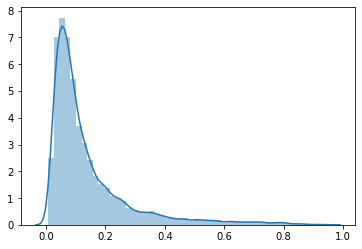

In [46]:
#4
sns.distplot(predictions.T[0])

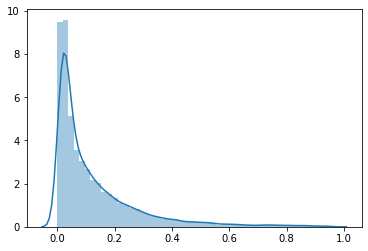

In [48]:
#8
sns.distplot(predictions.T[0])

In [27]:
pd.Series(predictions.T[0]).describe()

count    10982.000000
mean         0.140181
std          0.141170
min          0.007528
25%          0.053974
50%          0.090404
75%          0.167085
max          0.948450
dtype: float64

In [49]:
pd.Series(np.where(predictions>0.5,1,0).T[0]).value_counts()

0    10549
1      433
dtype: int64

In [0]:
sample_submission.target = predictions.T[0].T

In [0]:
sample_submission.to_csv('submission.csv', index=False)

In [32]:
pd.read_csv('submission.csv')

,image_name,target
0,ISIC_0052060,0.030733
1,ISIC_0052349,0.069912
2,ISIC_0058510,0.038792
3,ISIC_0073313,0.040374
4,ISIC_0073502,0.231237
...,...,...
10977,ISIC_9992485,0.091993
10978,ISIC_9996992,0.132469
10979,ISIC_9997917,0.204962
10980,ISIC_9998234,0.014278


In [33]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m {FLAGS['exp_name']}

100% 259k/259k [00:07<00:00, 37.6kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [35]:
!kaggle competitions submissions siim-isic-melanoma-classification

fileName             date                 description                   status    publicScore  privateScore  
-------------------  -------------------  ----------------------------  --------  -----------  ------------  
submission.csv       2020-06-01 15:28:00  resnet34mod_focal_224         complete  0.814        None          
submission (11).csv  2020-06-01 07:52:55  ResNet34 Mod 55x Loss Weight  complete  0.845        None          
submission (10).csv  2020-06-01 06:00:09  None                          complete  0.870        None          
submission (8).csv   2020-05-31 18:22:40  ResNet34                      complete  0.874        None          
submission (8).csv   2020-05-31 17:20:54                                complete  0.801        None          
submission (8).csv   2020-05-31 17:19:26                                error     None         None          
submission (8).csv   2020-05-31 17:18:18  None                          error     None         None          
